<a href="https://colab.research.google.com/github/nosignal00/researchSpace/blob/main/MultiAccountStrategy/backTestingWithChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys
import datetime as dt

base_dir = os.getcwd()
nb_path = base_dir + '/drive/MyDrive/Colab_rel'
sys.path.append(nb_path)
sys.path.append(nb_path + '/lib/python3.9/site-packages')

In [ ]:
# !chmod 755 /content/drive/MyDrive/Colab_rel/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc

In [ ]:
# !pip install --prefix=$nb_path yfinance

In [ ]:
# !pip install --prefix=$nb_path pulp

In [2]:
import yfinance as yf
import pytz

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import math
from pulp import *
import pdb


In [3]:
yf.pdr_override()
tz = pytz.timezone("America/New_York")
end = tz.localize(dt.datetime.now())
start = tz.localize(dt.datetime(2021, 11,10))

In [4]:
dfQQQ = yf.download('QQQ',start, end)
dfQQQ.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,392.470001,395.359985,387.529999,389.510010,385.570343,54937400
2021-11-11,392.570007,392.750000,390.239990,390.589996,386.639404,32243000
2021-11-12,391.769989,395.250000,390.130005,394.700012,390.707825,34730600
2021-11-15,395.910004,396.239990,392.100006,394.609985,390.618713,33716900
2021-11-16,393.859985,397.929993,393.660004,397.420013,393.400299,27872900


In [5]:
dfTQQQ = yf.download('TQQQ',start, end)
dfTQQQ.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,81.360001,83.199997,78.250000,79.535004,78.665733,96976800
2021-11-11,81.375000,81.495003,79.949997,80.180000,79.303688,57719000
2021-11-12,80.904999,83.035004,79.875000,82.724998,81.820869,63820400
2021-11-15,83.455002,83.654999,81.044998,82.699997,81.796135,69729200
2021-11-16,82.144997,84.705002,82.029999,84.410004,83.487457,51590800


In [ ]:
def moving_average_crossover_strategy(prices, short_window=50, long_window=200):
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = prices['close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = prices['close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   
    signals['positions'] = signals['signal'].diff()
    return signals


In [6]:
def percent_change_strategy(base_col, n_pct):
    base_price = None
    
    def strategy(row):
        prices = row.values
        nonlocal base_price
        if base_price is None:
            base_price = prices[base_col]
        signal = 0
        
        for i in range(1, len(prices)):
            if prices[base_col] >= base_price * (1 + n_pct/100):
                signal = 2  # Buy signal
                base_price = prices[base_col]
            elif prices[base_col] <= base_price * (1 - n_pct/100):
                signal = 1  # Sell signal
                base_price = prices[base_col]
        
        return signal
    
    return strategy


In [7]:
def trading_decision(signal, cash_balance, num_shares, stock_price):
    if signal == 2 and cash_balance > 0:
        num_shares_to_buy = cash_balance // stock_price
        return buy(stock_price, cash_balance, num_shares_to_buy)
    elif signal == 1 and num_shares > 0:
        return sell(stock_price, cash_balance, num_shares)
    else:
        return cash_balance, num_shares


In [8]:
def sell(stock_price, cash_balance, num_shares):
    cash_balance += stock_price * num_shares
    num_shares = 0
    return cash_balance, num_shares


In [9]:
def buy(stock_price, cash_balance, num_shares):
    if stock_price * num_shares > cash_balance:
        raise ValueError("Insufficient funds to buy shares.")
    cash_balance -= stock_price * num_shares
    return cash_balance, num_shares


In [10]:
def evenly_distribute_cost(total_capital, unit_costs):
    num_tasks = len(unit_costs)
    # Define the LP problem
    prob = LpProblem("Even_Cost_Distribution", LpMinimize)

    # Define the decision variables (positive integers)
    x = LpVariable.dicts("x", range(num_tasks), lowBound=0, cat='Integer')

    # Define the objective function (minimize the maximum gap)
    prob += lpSum([1 for i in range(num_tasks)])

    # Define the constraint for total cost within 90% to 100% of total capital
    total_cost = lpSum([unit_costs[i] * x[i] for i in range(num_tasks)])
    prob += total_cost >= 0.9 * total_capital
    prob += total_cost <= 0.99 * total_capital

    # Define the constraints (minimum gap)
    max_cost = LpVariable("max_cost", lowBound=0)
    for i in range(num_tasks):
        prob += x[i] * unit_costs[i] <= max_cost
    prob += max_cost <= total_cost / num_tasks

    # Solve the LP problem
    prob.solve()

    # Print the solution
    # print("Evenly distributed costs:")
    # for i in range(num_tasks):
    #     budget = round(x[i].value(), 2)
    #     cost = round(budget * unit_costs[i], 2)
    #     print(f"Task {i+1}: budget = {budget}, cost = {cost}")
    return [int(x[i].value()) for i in range(num_tasks)]



In [11]:
def calculate_shares_to_buy(row, cash):
    stock_prices = row.values
    shares_to_buy = evenly_distribute_cost(cash,stock_prices)
    return shares_to_buy

In [12]:
# 2021 11 15 부터 해보자
# 전략이 각각 가격이 아니라 두개의 관계값을 가지고 움직여야 하네. P1이 N 프로 떨어졌을 때 트리거 발동
cash = 15000 # 요게 계속 바뀌는 구나...

In [13]:
basePriceDf = pd.merge(left = dfQQQ["Adj Close"], right = dfTQQQ["Adj Close"], left_index=True, right_index=True)

In [ ]:
def cash_balance_closure(initial_cash_balance):
    def cash_balance_apply(df_row):
        nonlocal initial_cash_balance

        # Get the previous row's cash balance and signal value
        prev_cash_balance = initial_cash_balance
        prev_signal = df_row['signal']

        if prev_signal == 0:
            # If the previous signal is 0, do not execute `calculate_shares_to_buy`
            shares_to_buy = [0] * len(df_row.index[:-1])  # exclude the last column ('cash_balance')
        else:
            # Calculate shares to buy for each stock based on previous cash balance
            stock_prices = df_row.values[:-1]  # exclude the last column ('cash_balance')
            shares_to_buy = calculate_shares_to_buy(stock_prices, prev_cash_balance)

        # Calculate the new cash balance based on the shares bought and current stock prices
        stock_prices = df_row.values[:-1]  # exclude the last column ('cash_balance')
        new_cash_balance = sum(shares_to_buy * stock_prices)

        # Update the initial cash balance for the next row
        initial_cash_balance = new_cash_balance

        # Return the updated cash balance for the current row
        return new_cash_balance

    return cash_balance_apply


In [ ]:
initial_cash_balance = 1000
cash_balance_apply = cash_balance_closure(initial_cash_balance)
df['cash_balance'] = df.apply(cash_balance_apply, axis=1)

In [14]:
strategy = percent_change_strategy(0, 10)
basePriceDf['x_buy_sell'] = basePriceDf.apply(strategy, axis=1)


basePriceDf['shares_to_buy'] = basePriceDf.apply(calculate_shares_to_buy, axis=1, args=(cash,))

trading_decision(signal, cash_balance, num_shares, stock_price)

In [16]:
[397.686523 * 16, 86.143112 * 78]

[6362.984368, 6719.162736]

<Axes: xlabel='Date'>

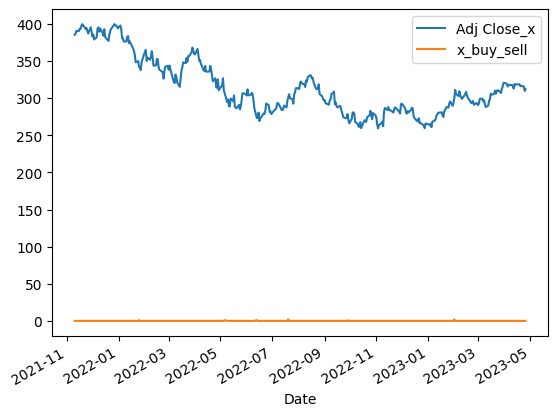

In [41]:
basePriceDf.plot(y=['Adj Close_x', 'x_buy_sell'], kind='line')

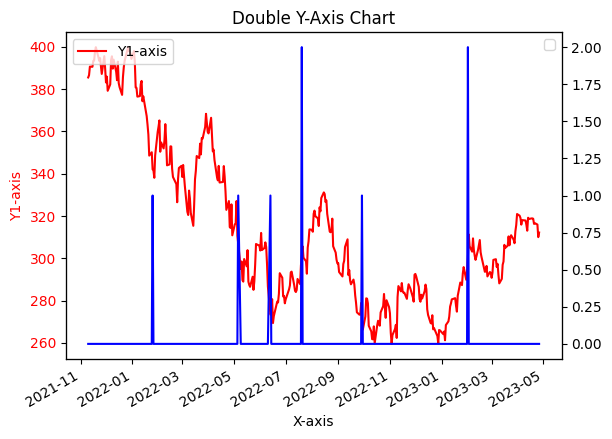

In [43]:
# create a line chart with two y-axes
ax = basePriceDf.plot(y='Adj Close_x', color='red', kind='line', label='Y1-axis')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y1-axis', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.legend(loc='upper left')

ax2 = ax.twinx()
basePriceDf.plot(y='x_buy_sell', color='blue', kind='line', ax=ax2, label='Y2-axis', secondary_y=True)
ax2.set_ylabel('Y2-axis', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.title('Double Y-Axis Chart')

# display the chart
plt.show()

## 시나리오
1. 현금 50 % 투자금 50% 에서 투자금을 동일한 비율로 나눠서 QQQ와 TQQQ에 분산
2. 투자금 전체를 동일한 비율로 나눠서 QQQ와 TQQQ에 분산
3. 내리면 팔고 오르면 사고.

### TEST SECTION

In [31]:
dates = pd.date_range('2022-01-01', periods=10)
prices = pd.DataFrame({
    'stock1': [10, 12, 15, 14, 13, 12, 13, 15, 16, 17],
    'stock2': [20, 22, 25, 24, 23, 22, 23, 25, 26, 27]
}, index=dates)

In [32]:
prices

,stock1,stock2
2022-01-01,10,20
2022-01-02,12,22
2022-01-03,15,25
2022-01-04,14,24
2022-01-05,13,23
2022-01-06,12,22
2022-01-07,13,23
2022-01-08,15,25
2022-01-09,16,26
2022-01-10,17,27


In [33]:
strategy = percent_change_strategy(0, 10)
signals = prices.apply(strategy, axis=0)

In [34]:
signals

stock1    0
stock2    2
dtype: int64

In [12]:
import pandas as pd
import numpy as np

# create a sample DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

# define the function to apply
def sqrt_func(x):
    return np.sqrt(x)

# apply the function to multiple columns
df[['A', 'B', 'C']] = df[['A', 'B', 'C']].apply(sqrt_func, axis=1)

# print the resulting DataFrame
print(df)

          A         B         C
0  1.000000  2.000000  2.645751
1  1.414214  2.236068  2.828427
2  1.732051  2.449490  3.000000
